In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [5]:
# 의미 없는 피처 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)",
    "insolation", "wind", "공휴일여부"
]

df_filtered = df.drop(columns=drop_cols)

# 최종 feature 목록 확인
feature_cols_filtered = [
    col for col in df_filtered.columns
    if col in ["humidity", "precipitation", "temperature", "총반입량",
               "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부"]
]

print("🧪 최종 사용 피처:", feature_cols_filtered)


KeyError: "['전일대비_반입량차이', '전일대비_반입량변화율(%)', 'insolation', 'wind', '공휴일여부'] not found in axis"

📊 DLinearPlus (log+lag) 예측 성능
RMSE: 550.94
MAE : 482.26
R2  : 0.7395


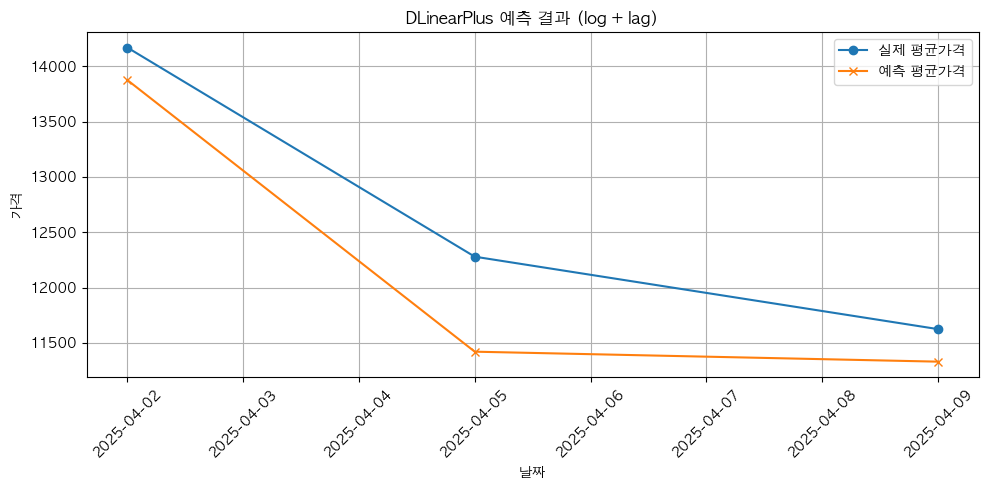

In [8]:
# 0. 필요 라이브러리
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-04-02")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 3. PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. DLinearPlus 모델 정의
class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# 5. 학습
model = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 6. 예측 및 복원
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    preds_log = model(X_test_tensor).numpy()
    preds = np.expm1(preds_log)  # log1p 복원
    y_true = np.expm1(y_test.values)

# 7. 평가
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print("📊 DLinearPlus (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 8. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], preds, label="예측 평균가격", marker='x')
plt.title("DLinearPlus 예측 결과 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 DLinearPlus (log+lag) 예측 성능
RMSE: 661.03
MAE : 586.61
R2  : 0.8179


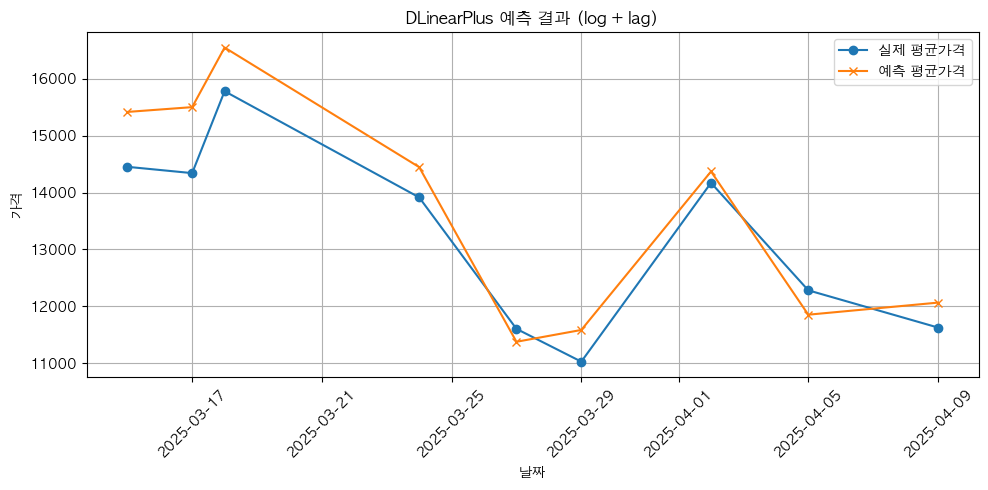

In [6]:
# 0. 필요 라이브러리
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-03-10")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 3. PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. DLinearPlus 모델 정의
class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# 5. 학습
model = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 6. 예측 및 복원
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    preds_log = model(X_test_tensor).numpy()
    preds = np.expm1(preds_log)  # log1p 복원
    y_true = np.expm1(y_test.values)

# 7. 평가
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print("📊 DLinearPlus (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 8. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], preds, label="예측 평균가격", marker='x')
plt.title("DLinearPlus 예측 결과 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 DLinearPlus (log+lag) 예측 성능
RMSE: 770.16
MAE : 627.84
R2  : 0.8270


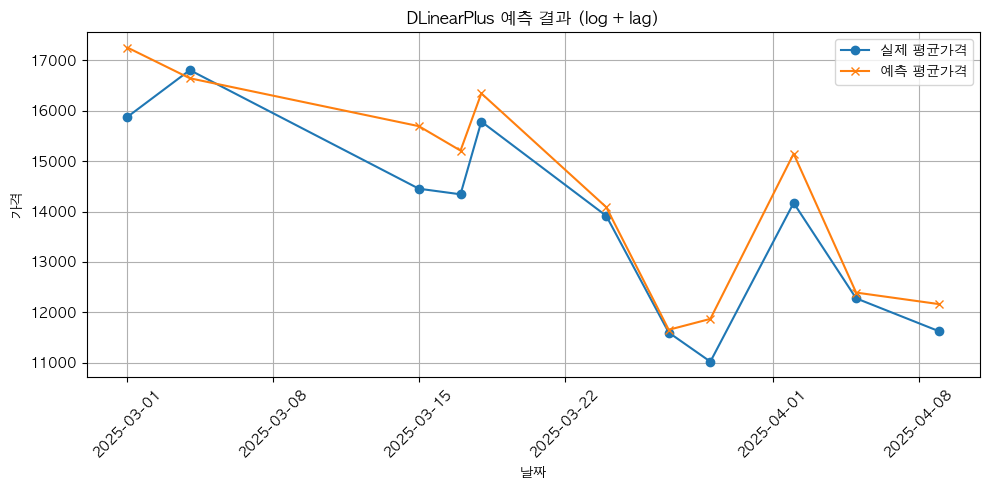

In [9]:
# 0. 필요 라이브러리
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 컬럼 제거
drop_cols = [
    "전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"
]
df = df.drop(columns=drop_cols)

# lag 및 log 변환 추가
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용 피처
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]

# 학습/테스트셋 분할
target_col = "log_평균가격"
target_start = pd.to_datetime("2025-02-09")
target_end = pd.to_datetime("2025-04-09")

df = df.dropna(subset=[target_col] + feature_cols)
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 2. 스케일링
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 3. PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. DLinearPlus 모델 정의
class DLinearPlus(nn.Module):
    def __init__(self, input_dim):
        super(DLinearPlus, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

# 5. 학습
model = DLinearPlus(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 6. 예측 및 복원
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    preds_log = model(X_test_tensor).numpy()
    preds = np.expm1(preds_log)  # log1p 복원
    y_true = np.expm1(y_test.values)

# 7. 평가
rmse = np.sqrt(mean_squared_error(y_true, preds))
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print("📊 DLinearPlus (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 8. 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"], preds, label="예측 평균가격", marker='x')
plt.title("DLinearPlus 예측 결과 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
